## NIPS SCM Spin Test 

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-04-28 16:11:04.876855: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-28 16:11:06.434317: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 16:11:09.054009: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib as npm

  au

In [13]:
import importlib
import data

import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
from models import *
from data import * 
from sim import *

import models
import models.metrics
from models.metrics import *

from sim.null import fit_scm, fit_scm_closed, fit_scm_closed_with_scalar_bias, fit_scm_closed_with_gcv, grid_search_alpha_with_gcv
from sim.null import get_best_pls_model, run_spin_test, run_spin_test_random, run_spin_test_precomputed_colored


## Specify connectome and transcriptome

Assign features and targets

In [4]:
# S400
X = load_transcriptome(parcellation='S400', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
X_pca = load_transcriptome(parcellation='S400', run_PCA=True, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=False, measure='SC', hemisphere='both', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=False, measure='FC', hemisphere='both', include_labels=True)
Y = Y_fc
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]
X_pca = X_pca[valid_indices]
Y = Y[valid_indices][:, valid_indices]


Number of components for 95% variance PCA: 27


## Find Best True Fit SCM model

alpha=0      | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=1e-05  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.0001 | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.001  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.01 | Tr(H)=728.99
alpha=0.01   | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.06 | Tr(H)=728.94
alpha=0.1    | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.65 | Tr(H)=728.35
alpha=1      | GCV=1.1321e-07 | Residual=6.9415e+01 | τ=206302.44 | Tr(H)=722.56
alpha=10     | GCV=1.1332e-07 | Residual=6.9465e+01 | τ=206355.23 | Tr(H)=669.77
alpha=100    | GCV=1.1874e-07 | Residual=7.1201e+01 | τ=206630.65 | Tr(H)=394.35


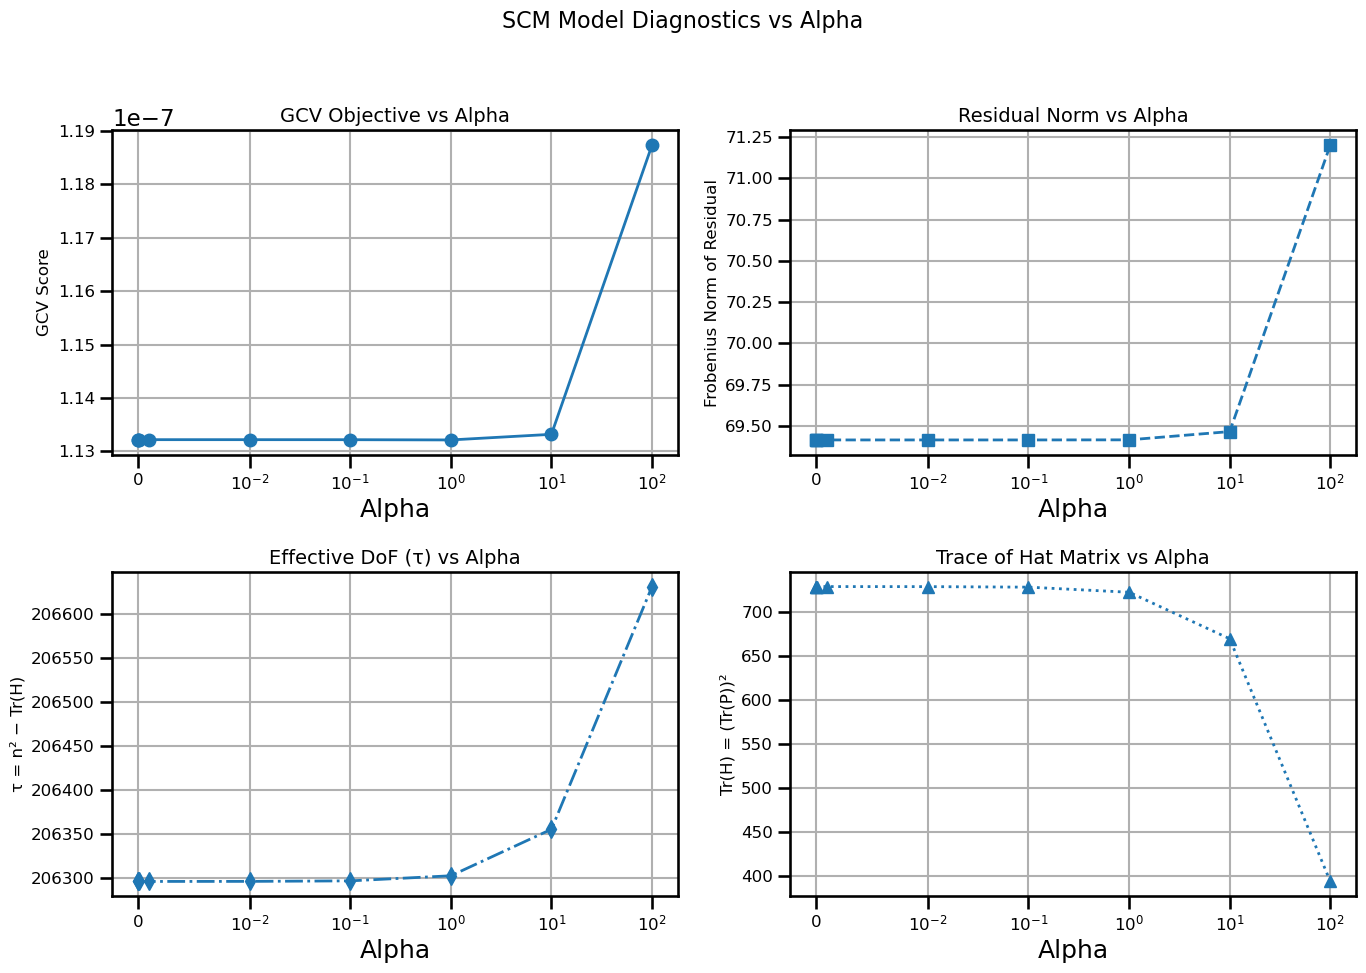

In [5]:
# # Define alpha values and run search
alphas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
results = grid_search_alpha_with_gcv(X_pca, Y, alphas)


SCM model metrics:
Pearson r: 0.560
R-squared: 0.30452
MSE: 0.02327


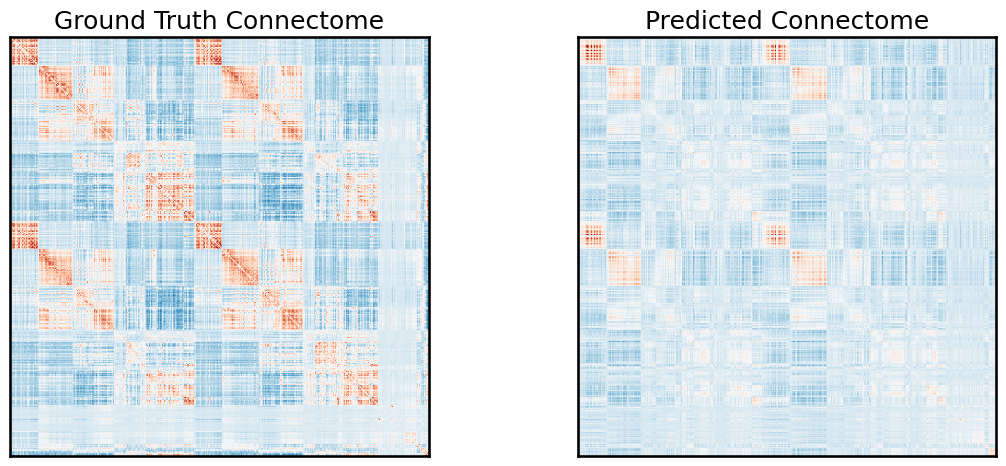

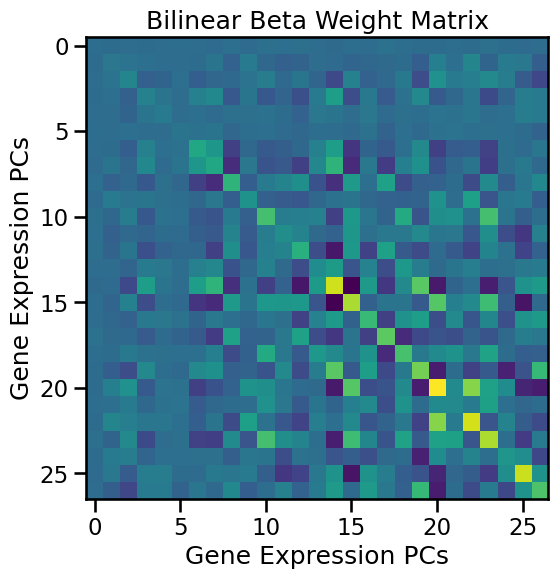

In [6]:
O, Y_pred = fit_scm_closed(X_pca, Y, alpha=0.1, plot=True)


SCM model metrics:
Pearson r: 0.560
R-squared: 0.31329
MSE: 0.02298


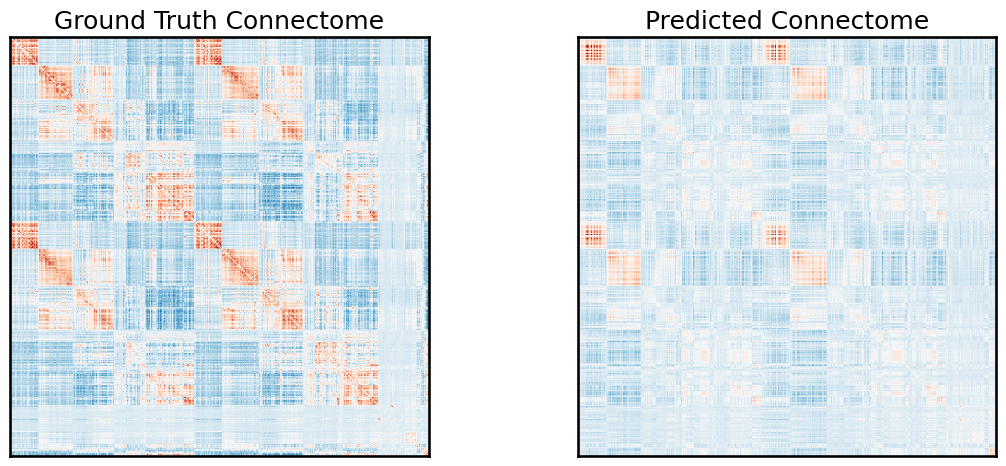

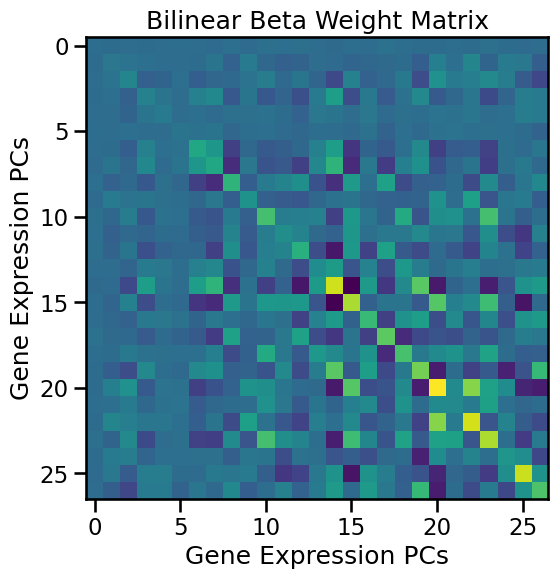

In [7]:
O, b, Y_pred = fit_scm_closed_with_scalar_bias(X_pca, Y, alpha=0.1, plot=True)

## Fit Best True PLS Model

5
10
15
20
25


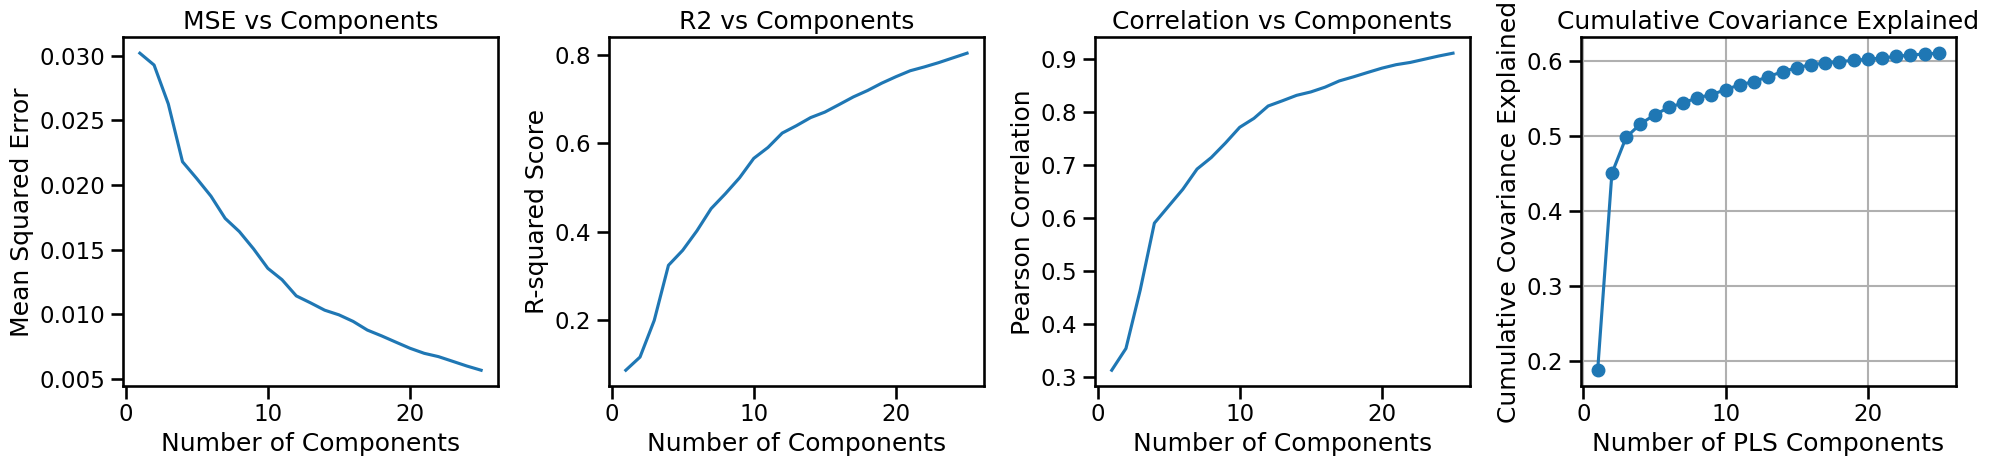

Best model performance (at elbow point):
Number of components: 9
MSE: 0.0151
R2: 0.5219
Mean correlation: 0.7416


In [8]:
best_pls_model, metrics = get_best_pls_model(X, Y, max_components=25)

## Comparison to null spin tests

In [18]:
spins_df_1k = pd.read_csv('./data/enigma/1000_null_spins.csv')
spins_df_10k = pd.read_csv('./data/enigma/10000_null_spins.csv')
spins_df_spatial_random = pd.read_csv('./data/enigma/1000_spatial_random_spins.csv')
spins_df_random = pd.read_csv('./data/enigma/1000_true_random_spins.csv')
spins_df_10k.head()

cortical_spins  \
0  [34, 35, 33, 102, 101, 99, 140, 152, 100, 174,...   
1  [31, 33, 135, 171, 162, 154, 35, 98, 158, 101,...   
2  [165, 166, 124, 167, 114, 125, 133, 119, 113, ...   
3  [48, 106, 110, 109, 55, 199, 179, 194, 54, 182...   
4  [185, 184, 64, 86, 87, 63, 85, 187, 61, 58, 56...   

                                   subcortical_spins  cortical_cost  \
0  [53, 52, 49, 51, 54, 50, 33, 34, 42, 48, 29, 4...   14676.201766   
1  [32, 55, 53, 52, 31, 51, 8, 34, 6, 54, 10, 50,...   14223.071041   
2  [54, 55, 32, 46, 48, 50, 3, 29, 5, 31, 30, 34,...   14066.498745   
3  [2, 55, 0, 49, 54, 50, 29, 3, 13, 51, 4, 47, 9...   13520.685713   
4  [4, 53, 46, 50, 28, 42, 13, 0, 34, 47, 49, 48,...   13896.760066   

   subcortical_cost    total_cost  mean_error_rank  total_cost_rank  \
0       2342.839271  17019.041037      4160.000000           6710.0   
1       3079.720650  17302.791691      8809.666667           7793.0   
2       2193.130687  16259.629432      2537.333333           3951.0   
3       2364.827011  15885.512724      4576.666667           2936.0   
4       3108.012640  17004.772706      5959.666667           6661.0   

   SA_error_rank  poly_error_rank  standardized_SA_error  ...  SA_lambda_PCA  \
0          678.0           5092.0               2.026880  ...      39.069998   
1         9389.0           9247.0               7.754004  ...      18.690197   
2         1491.0           2170.0               3.195251  ...      34.530601   
3         4261.0           6533.0               5.363485  ...      25.958393   
4         5662.0           5556.0               6.022278  ...      25.778299   

   SA_inf_PCA   poly_a1   poly_a2   poly_a3       poly_a4  poly_a1_PCA  \
0   -0.164938  0.892056 -0.020372  0.000229 -7.939946e-07     0.892085   
1    0.100440  0.895892 -0.017695  0.000150 -3.050474e-07     0.815554   
2   -0.104178  0.990390 -0.023210  0.000244 -7.754920e-07     0.969185   
3    0.007003  0.955965 -0.020002  0.000183 -4.740132e-07     0.908789   
4    0.011122  0.946094 -0.020804  0.000202 -5.556576e-07     0.959338   

   poly_a2_PCA  poly_a3_PCA   poly_a4_PCA  
0    -0.026995     0.000288 -1.034092e-06  
1    -0.019567     0.000131 -1.852663e-07  
2    -0.029299     0.000301 -1.024482e-06  
3    -0.023540     0.000193 -4.967189e-07  
4    -0.027698     0.000260 -7.725980e-07  

[5 rows x 25 columns]

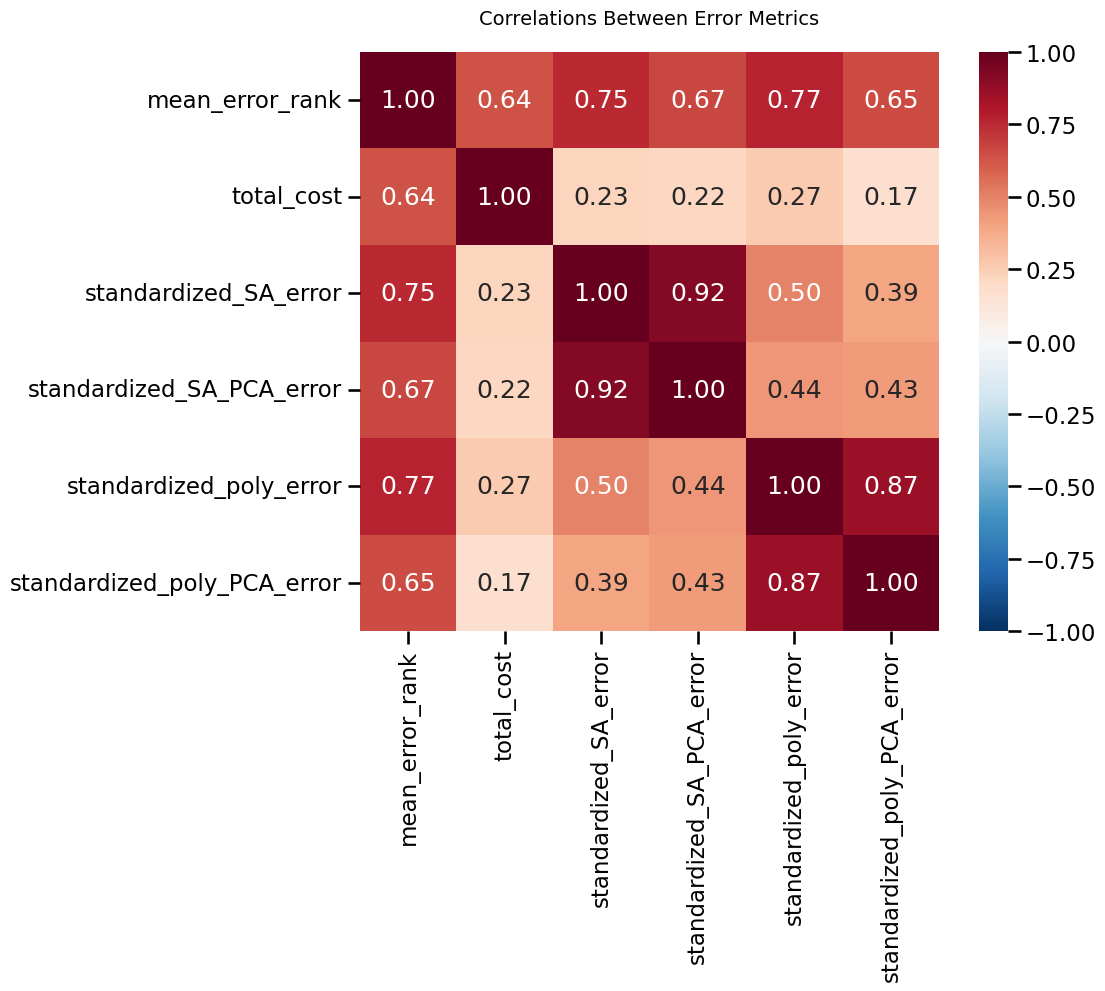

In [11]:
# Calculate correlations between error metrics
error_columns = ['mean_error_rank', 'total_cost', 'standardized_SA_error', 'standardized_SA_PCA_error', 
                'standardized_poly_error', 'standardized_poly_PCA_error']

# Compute correlation matrix
corr_matrix = spins_df_1k[error_columns].corr()

# Create figure
plt.figure(figsize=(12,10))

# Plot heatmap
sns.heatmap(corr_matrix, 
            annot=True, # Show correlation values
            cmap='RdBu_r', # Red-Blue diverging colormap
            vmin=-1, vmax=1, # Fix scale from -1 to 1
            center=0, # Center colormap at 0
            square=True, # Make cells square
            fmt='.2f') # Round correlation values to 2 decimal places

plt.title('Correlations Between Error Metrics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()




Fit spatial null model: 

- Idea is that autocorrelation in gene expression, X, may drive the model solution
- To address this we can generate a spatial permutation of either the gene expression data or the connectome data and refit the model
- Here we will permute the target data as in Hansen, 2021

- The spin test embodies the null hypothesis that genes and connectivity values are spatially correlated with each other because of inherent spatial autocorrelation.
- In Hansen, 2021, the P value is computed as the proportion of null singular values that are greater in magnitude than the empirical singular values.
- Thus, the P value represents the probability that the observed spatial correspondence between genes and connectivity values could occur by randomly correlating maps with comparable spatial autocorrelation

- In our case the null distribution could be the pearson-r values (or other metrics) of the best model as determined by elbow point.


permutation: 0
permutation: 50


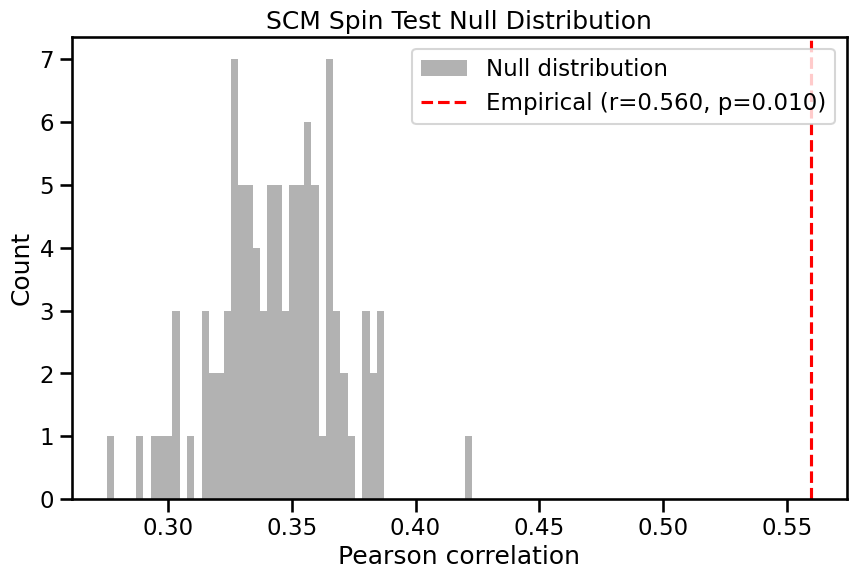

In [25]:
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_1k,
    model_type='SCM',
    sort_spins='mean_error_rank',
    n_perms=100
)

permutation: 0
permutation: 50


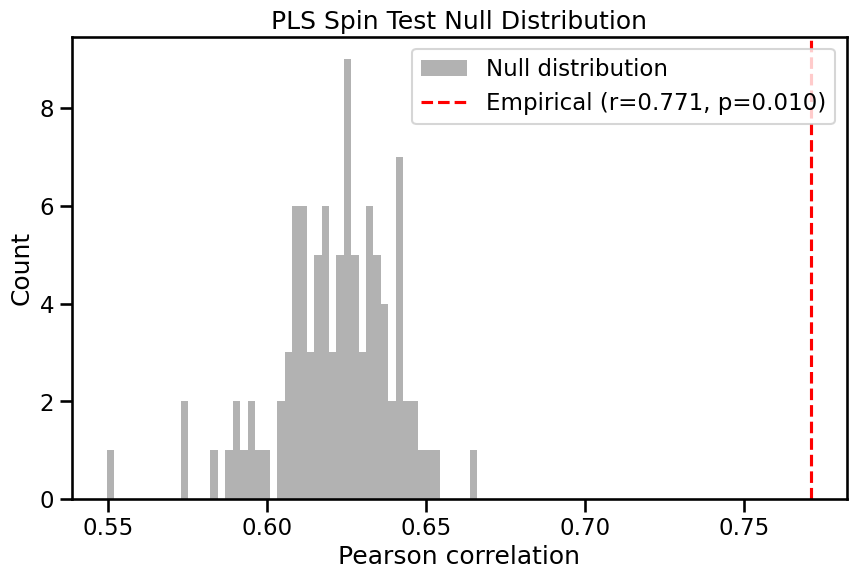

In [26]:
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_1k,
    model_type='PLS',
    num_components=10,
    sort_spins='mean_error_rank',
    n_perms=100
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150


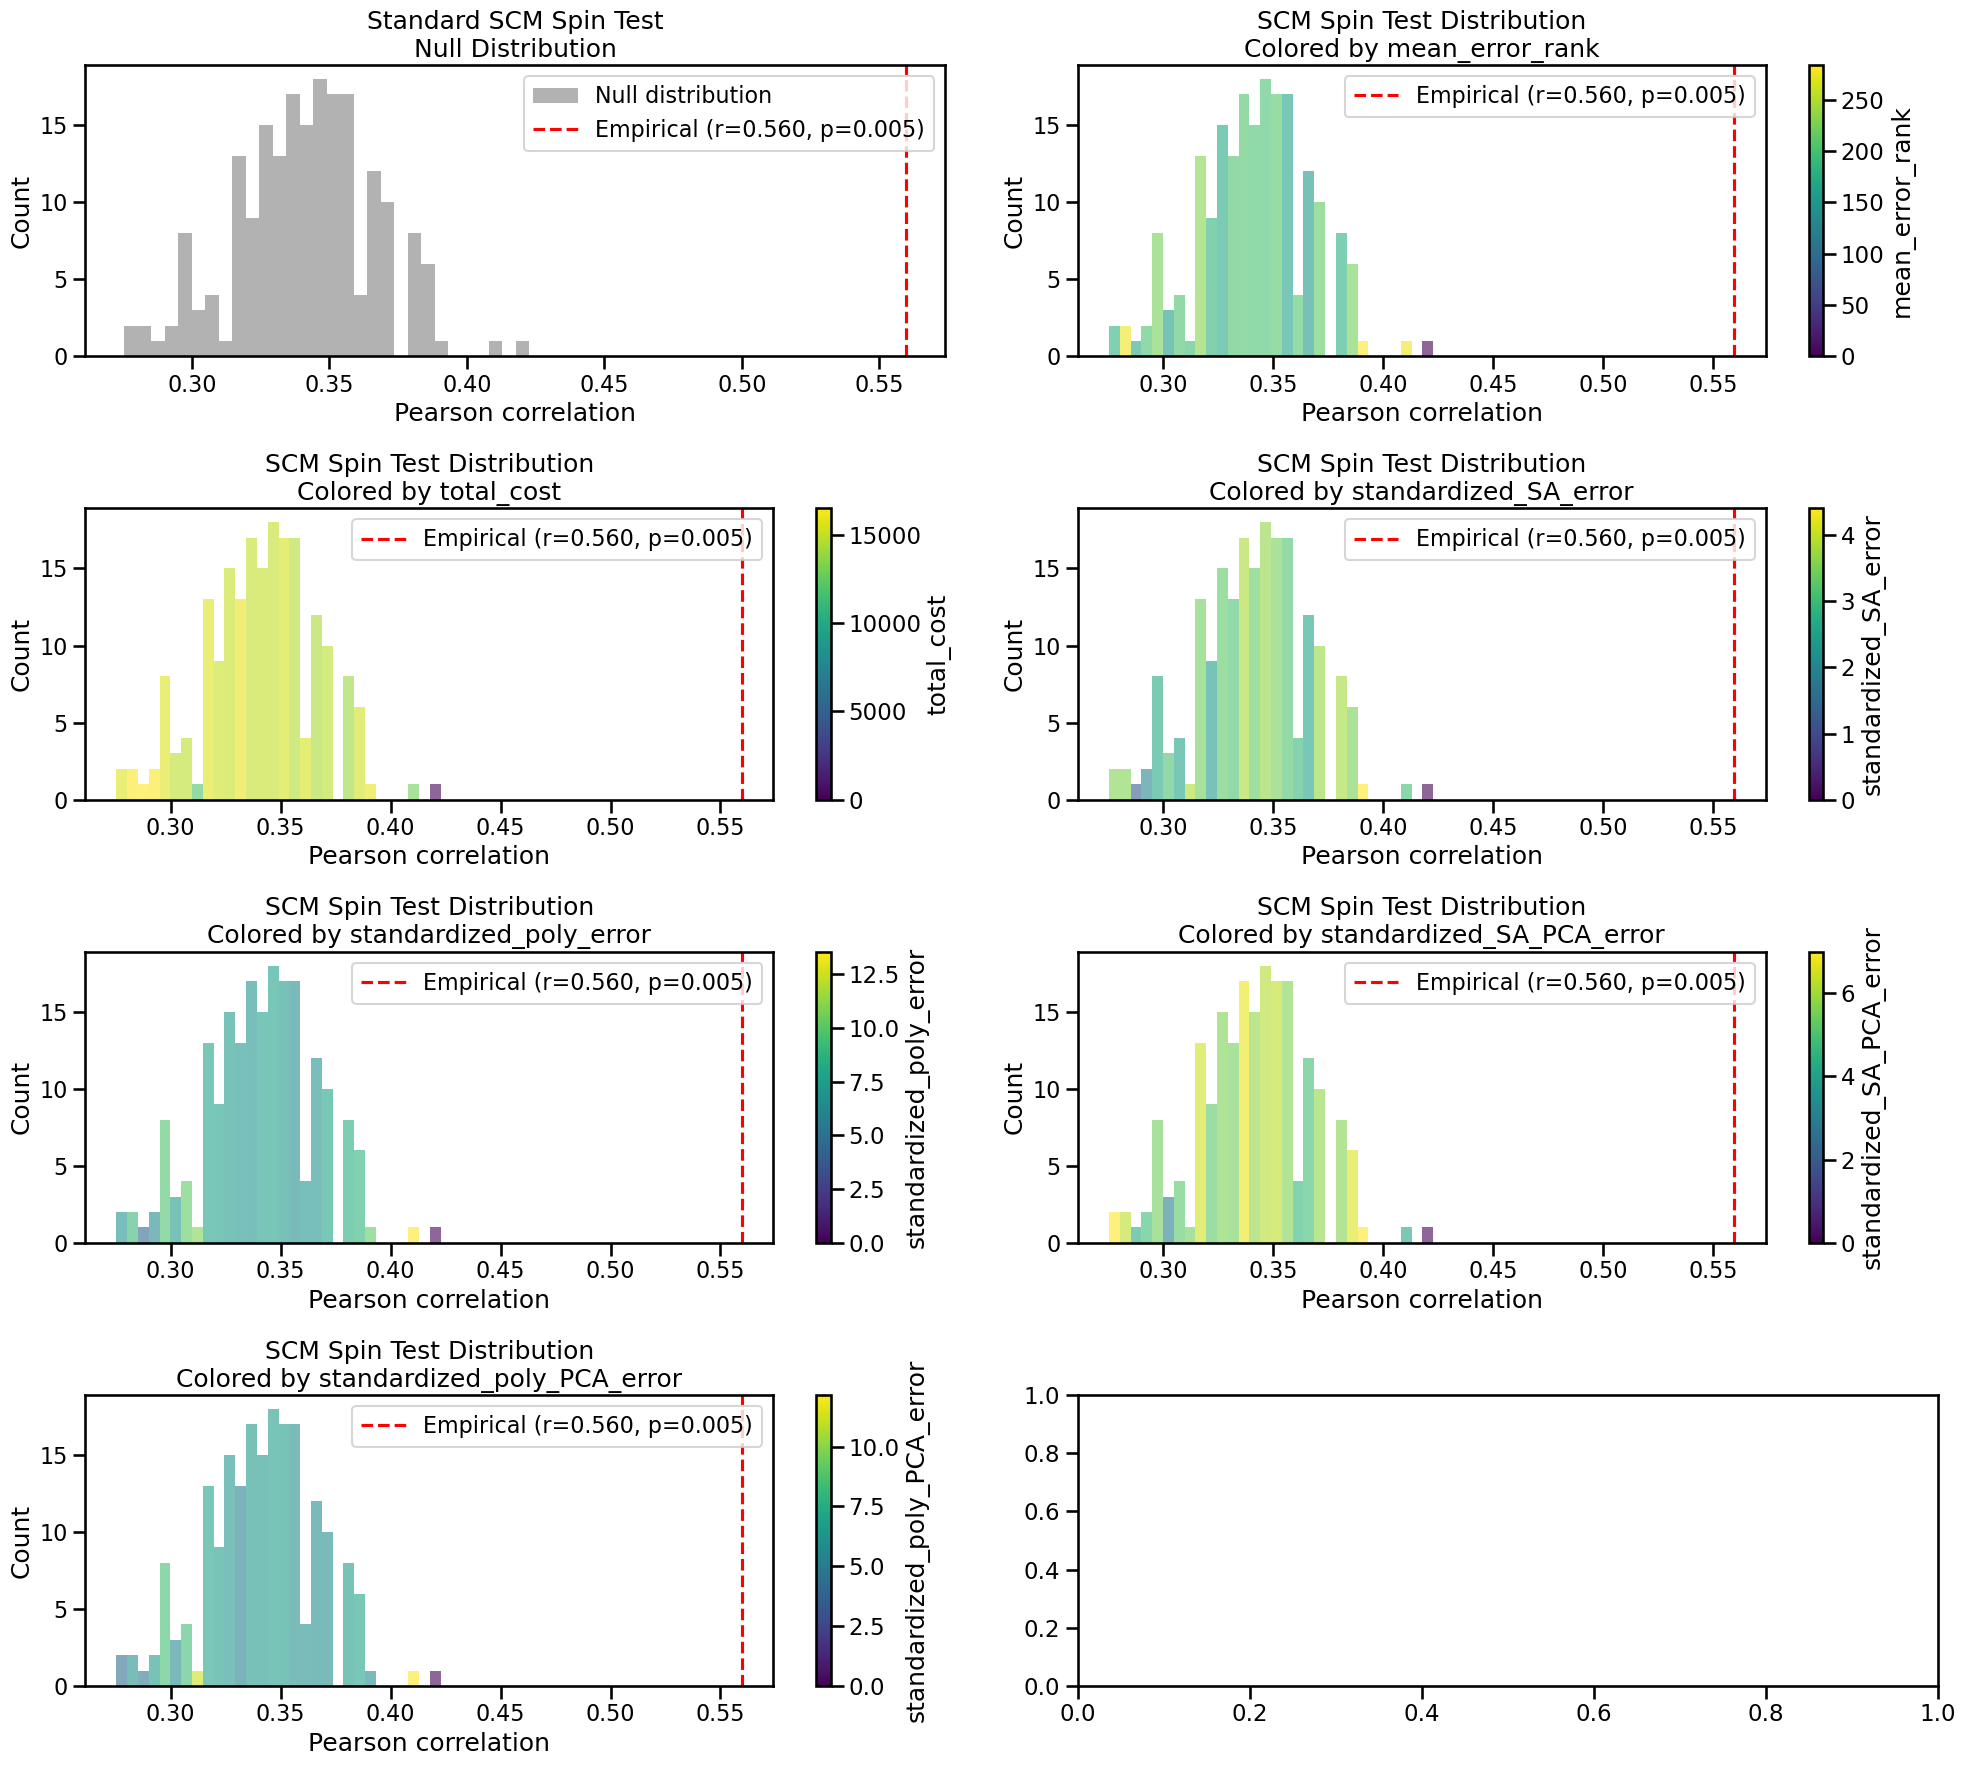

In [35]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_1k,
    model_type='SCM',
    sort_spins='mean_error_rank',
    n_perms=200,
    bins=30
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150


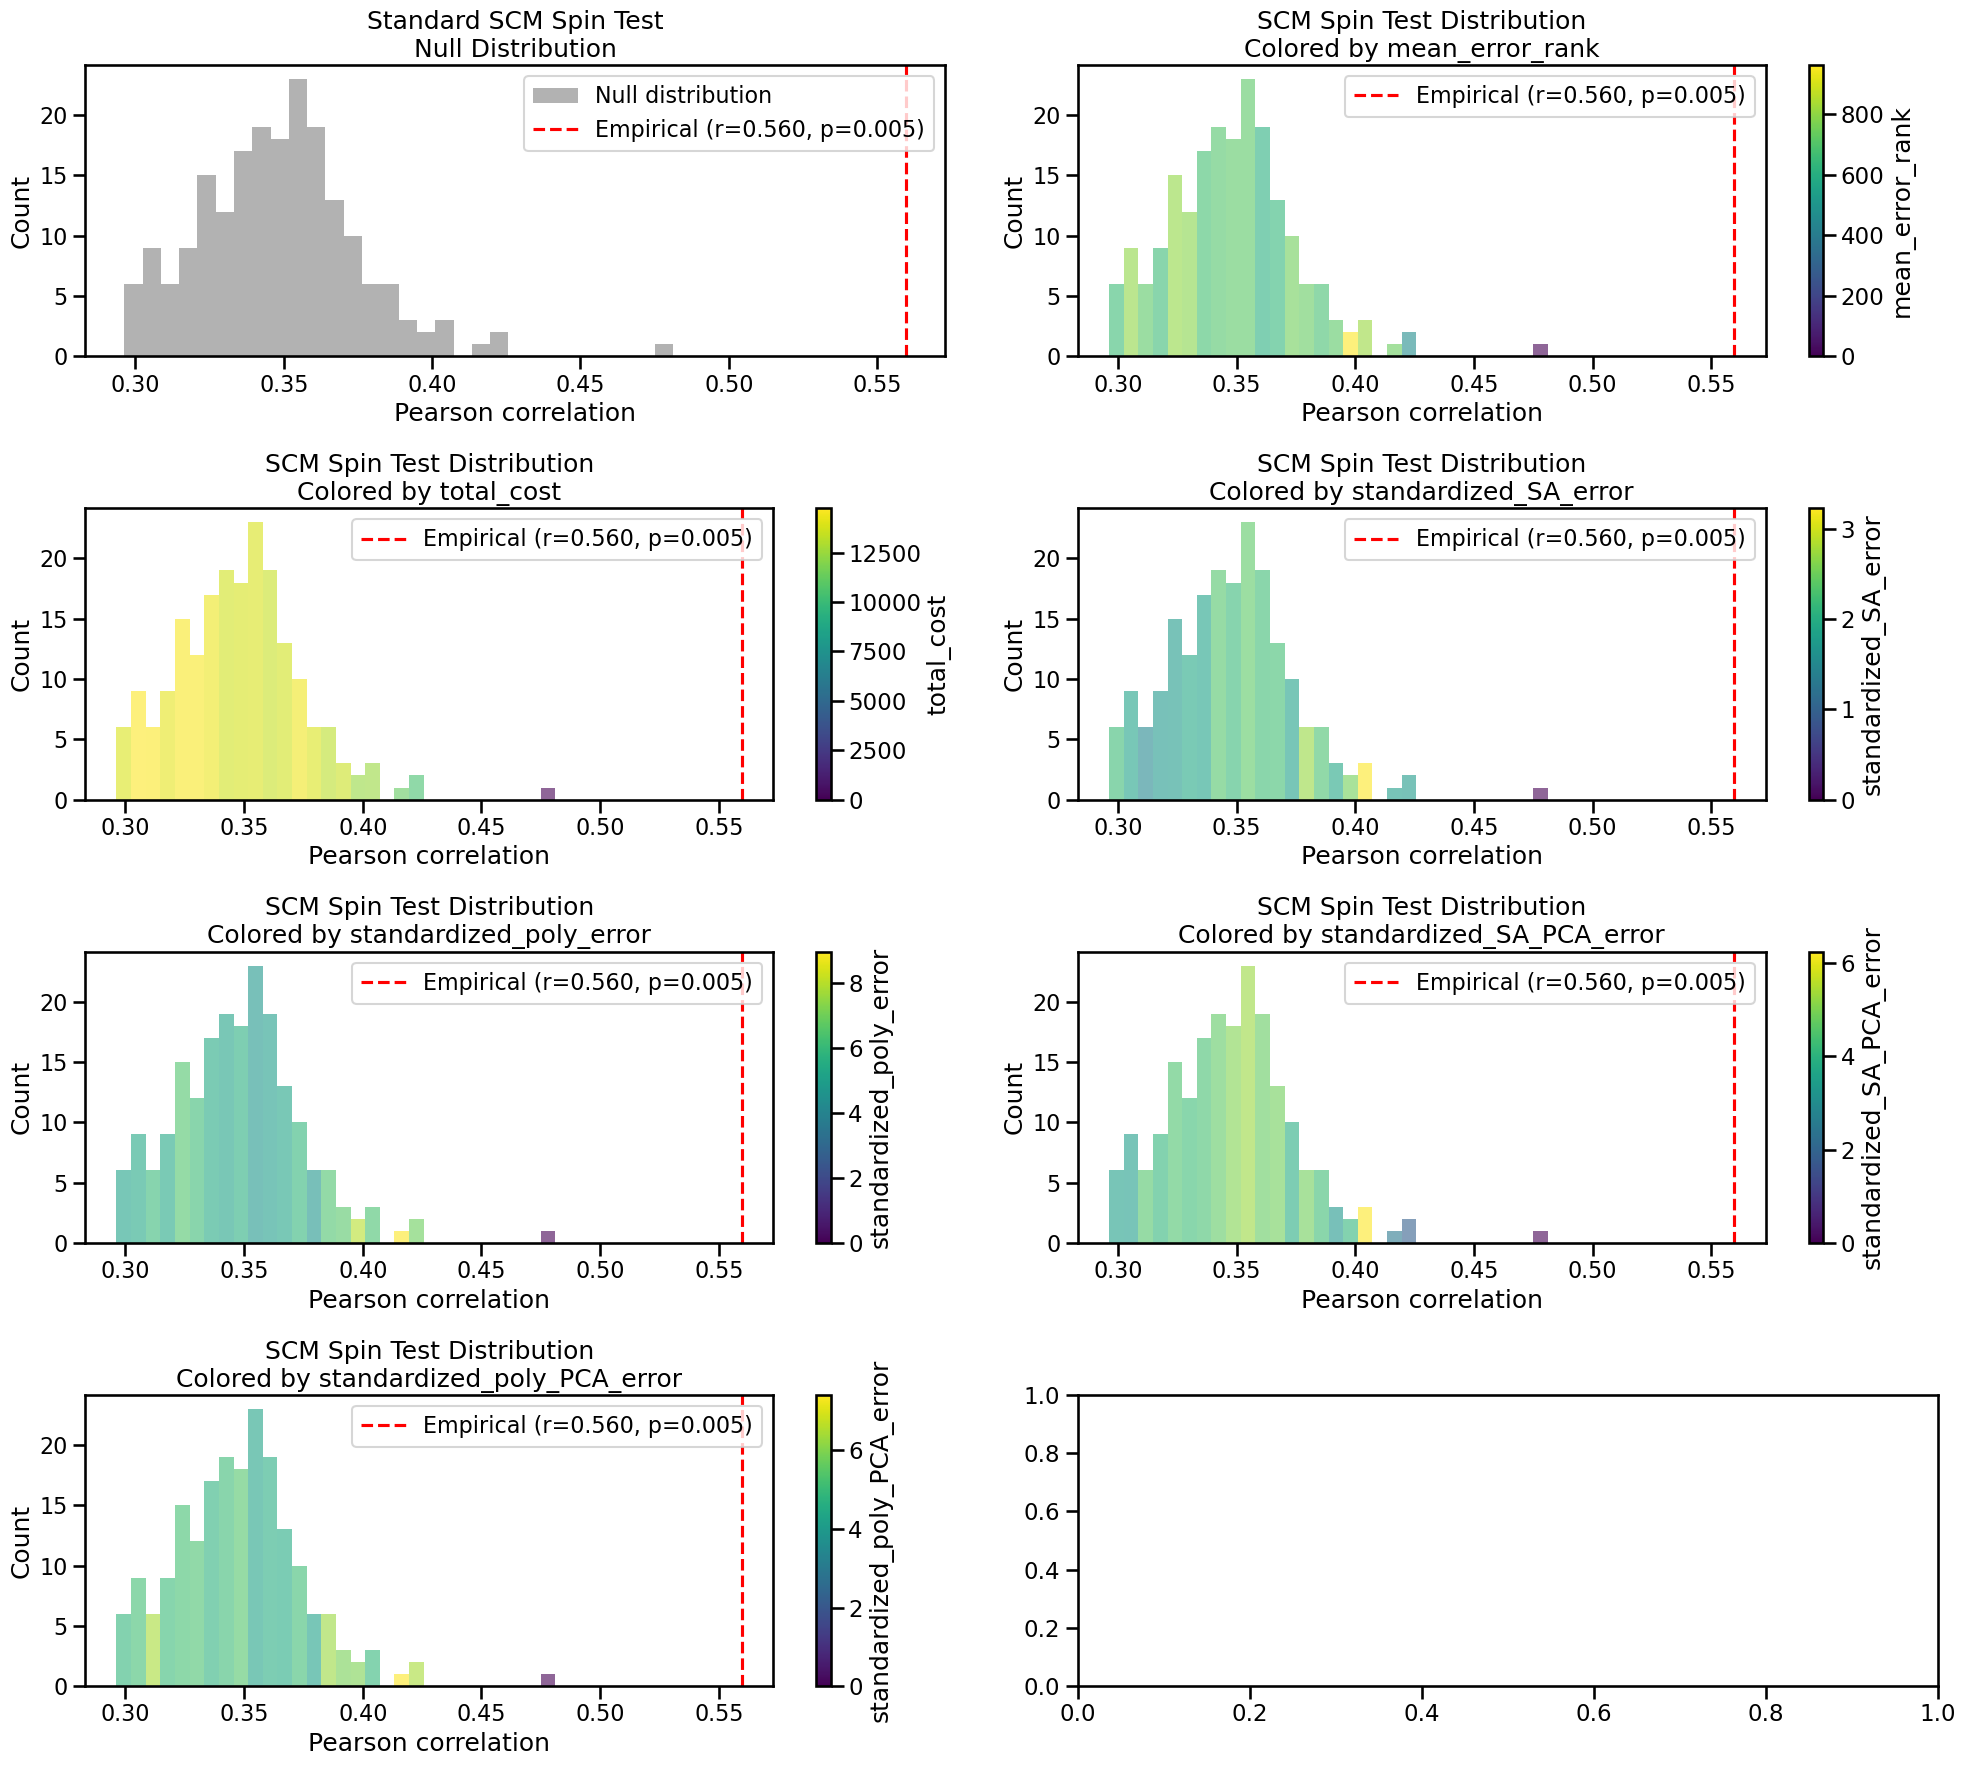

In [36]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='SCM',
    sort_spins='mean_error_rank',
    n_perms=200,
    bins=30
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150


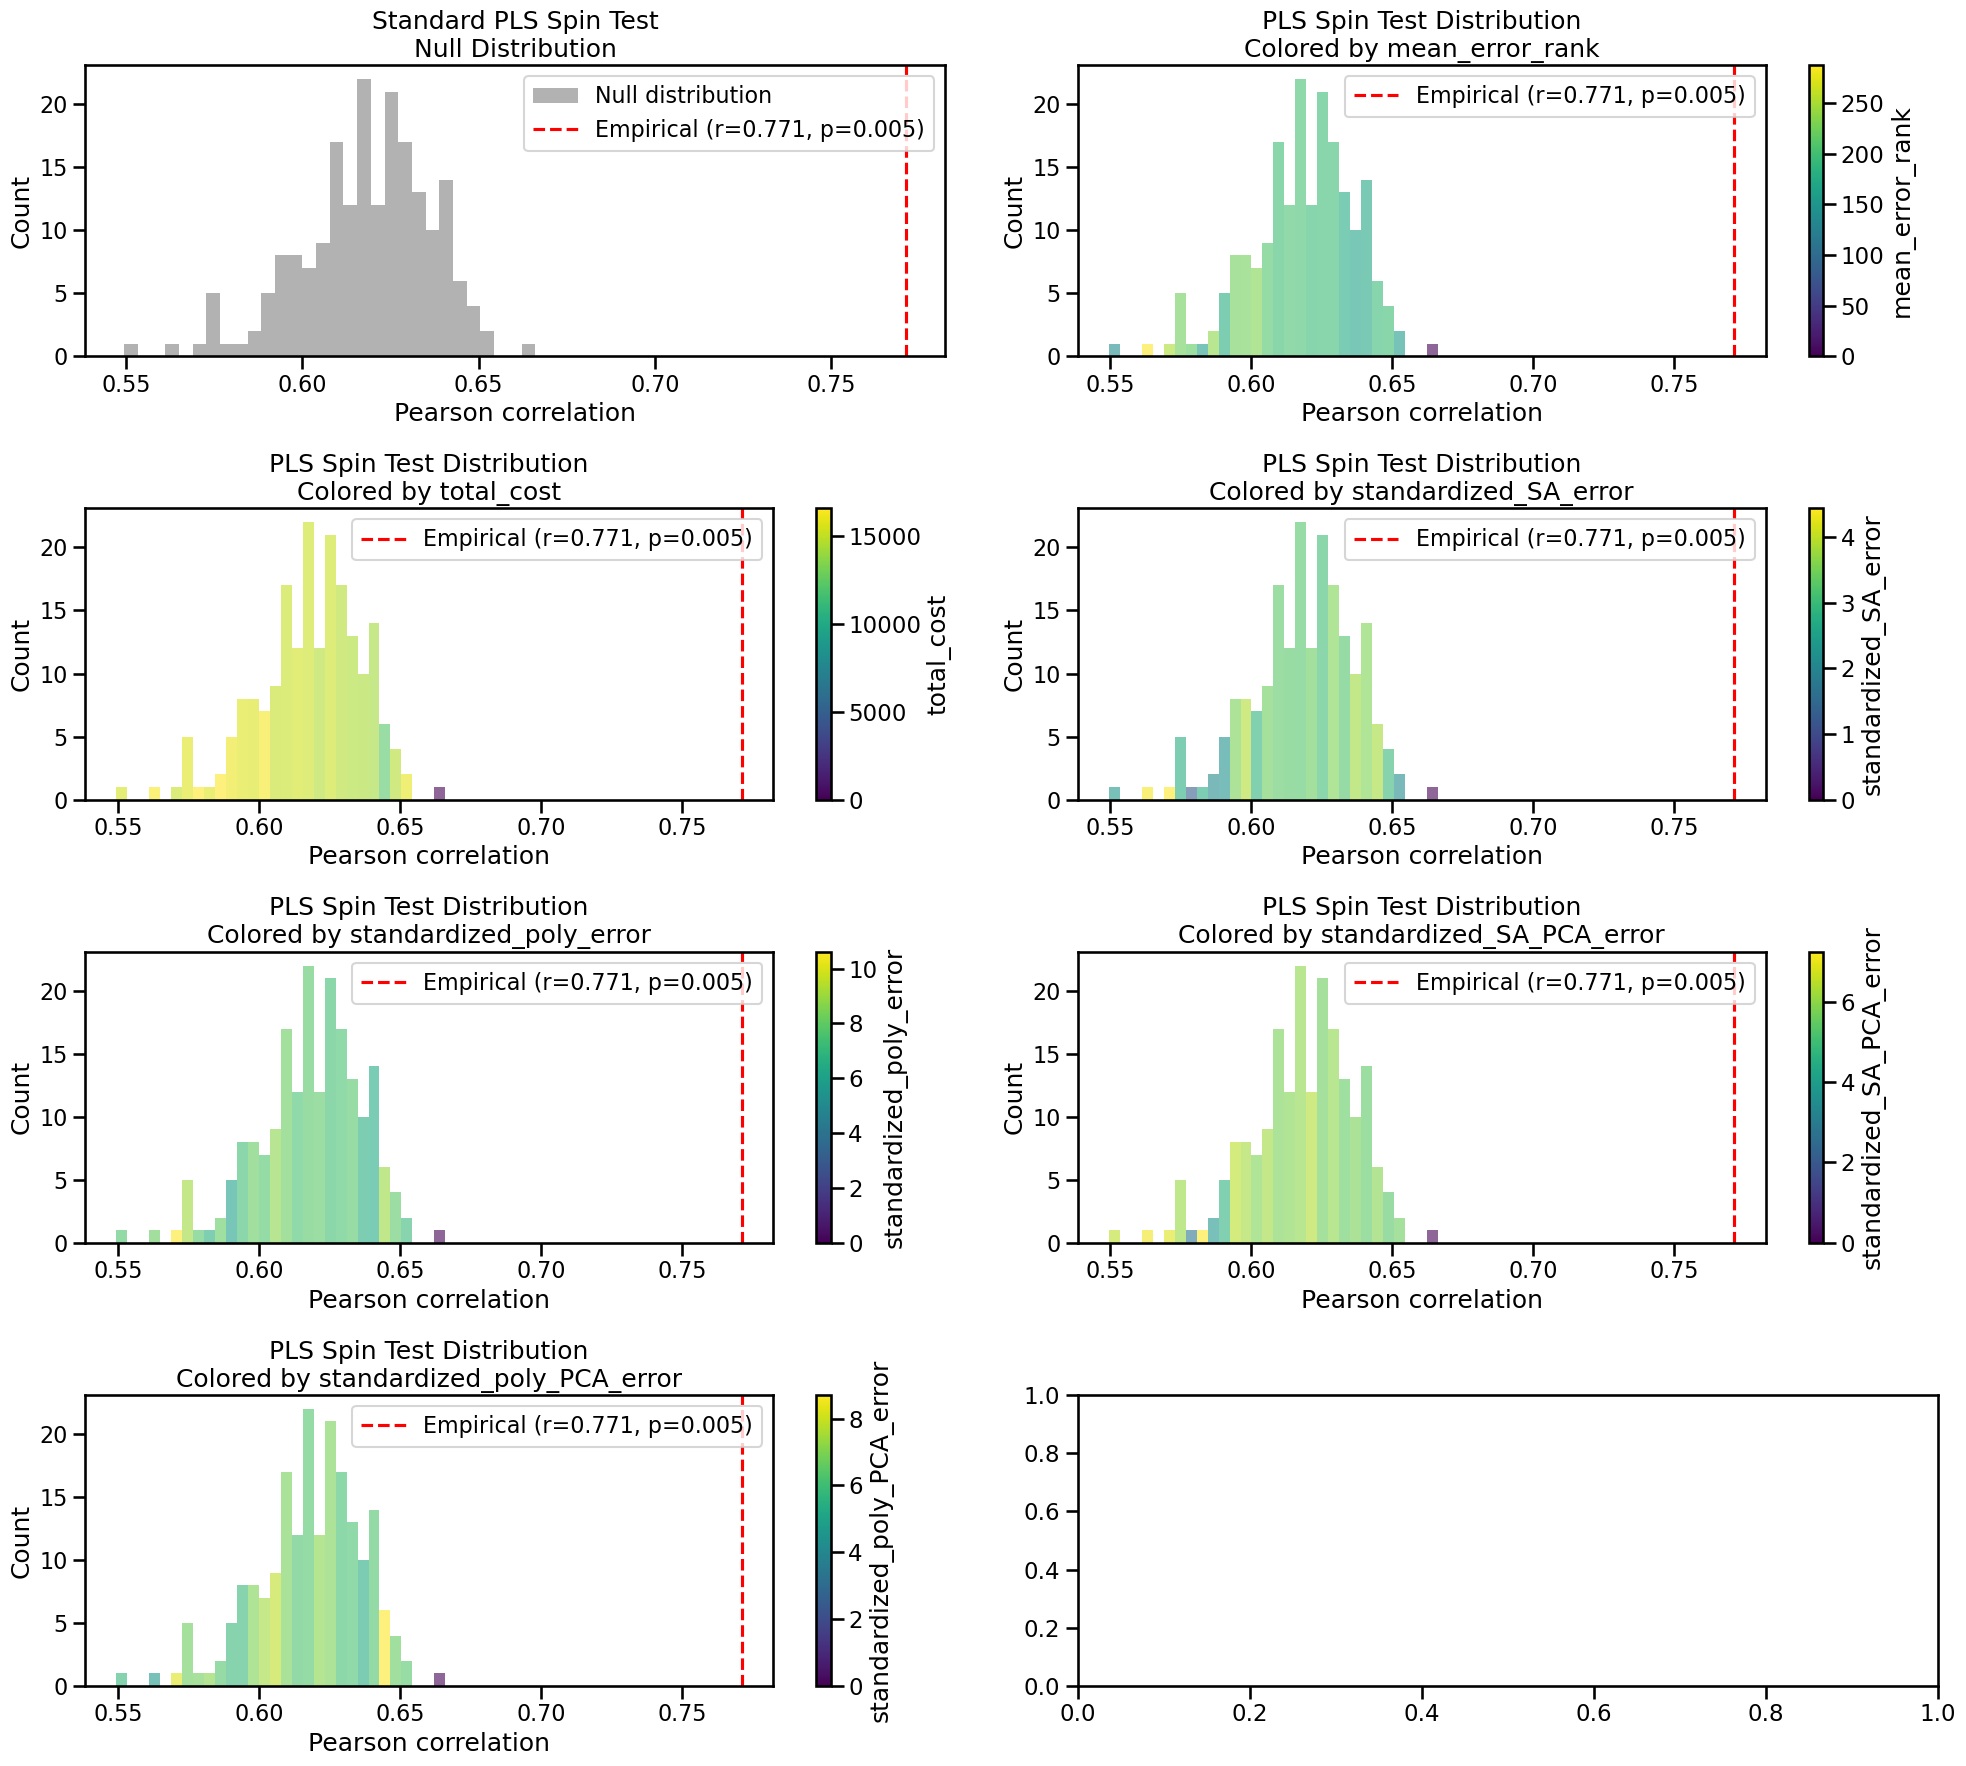

In [37]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_1k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=200,
    bins=30
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150


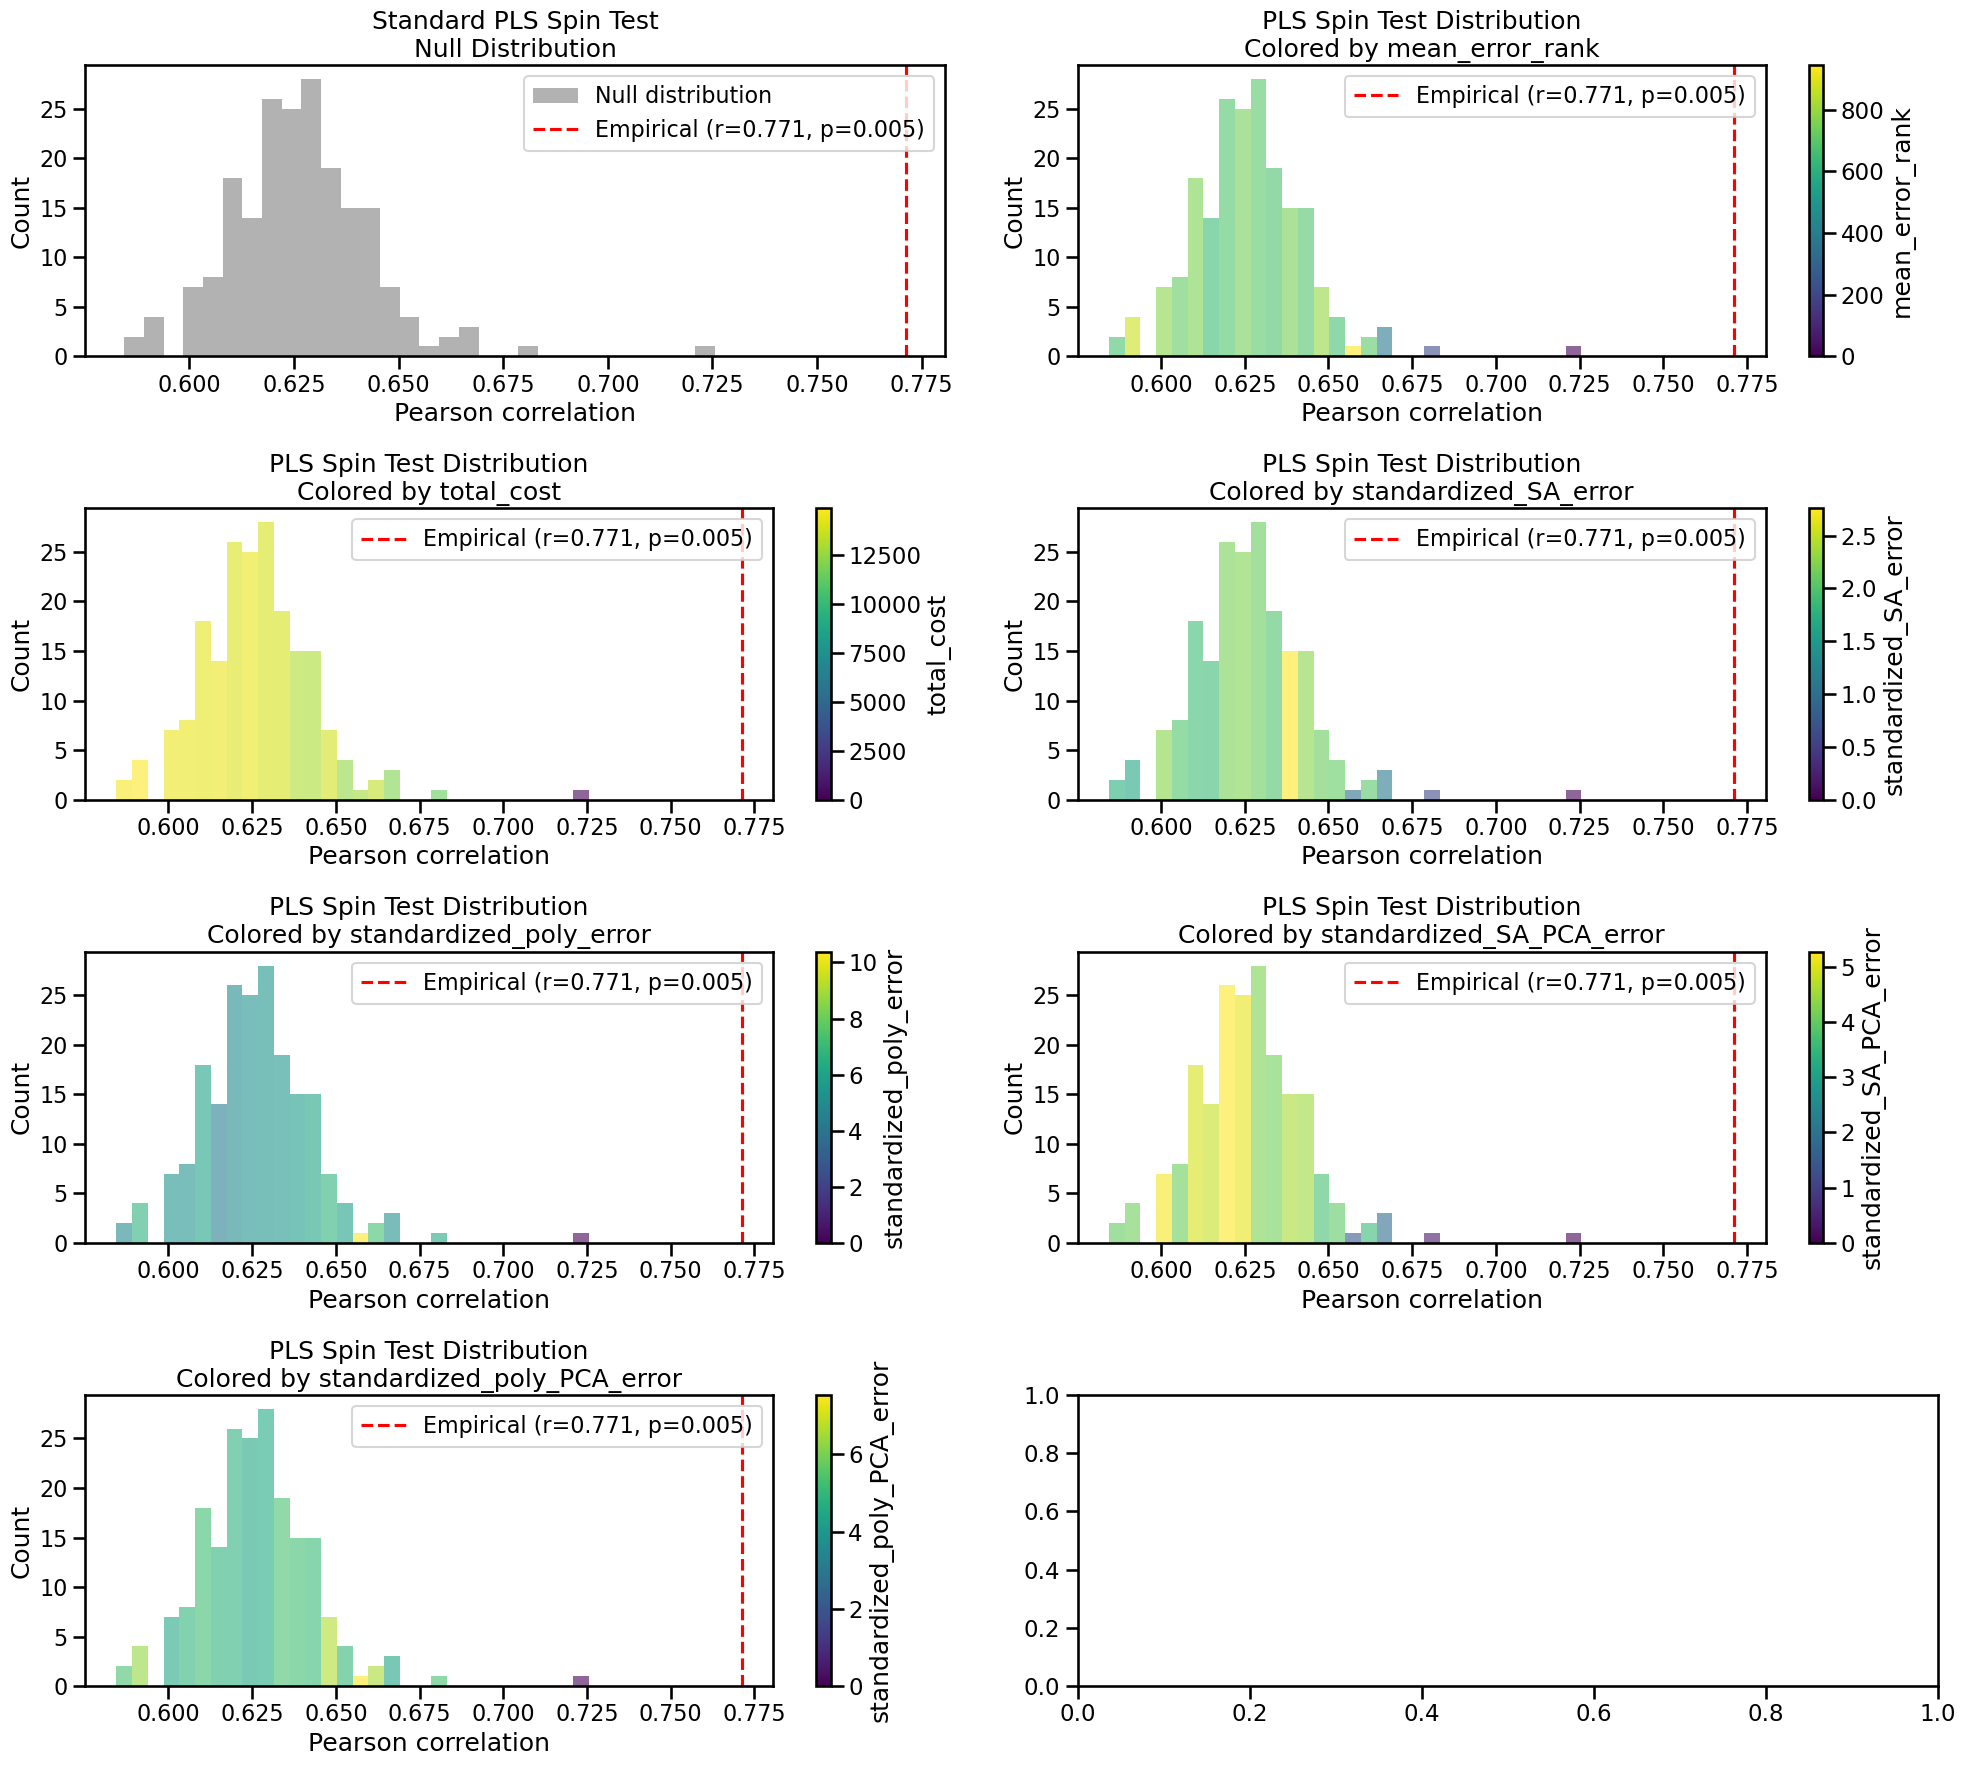

In [38]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=200,
    bins=30
)

#### Compare null distributions for 1k best, 1k spins excluding best, 1k spatial random, 1k true random

Generate distribution for all 10k spins

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950
permutation: 1000
permutation: 1050
permutation: 1100
permutation: 1150
permutation: 1200
permutation: 1250
permutation: 1300
permutation: 1350
permutation: 1400
permutation: 1450
permutation: 1500
permutation: 1550
permutation: 1600
permutation: 1650
permutation: 1700
permutation: 1750
permutation: 1800
permutation: 1850
permutation: 1900
permutation: 1950
permutation: 2000
permutation: 2050
permutation: 2100
permutation: 2150
permutation: 2200
permutation: 2250
permutation: 2300
permutation: 2350
permutation: 2400
permutation: 2450
permutation: 2500
permutation: 2550
permutation: 2600
permutation: 2650
permutation: 2700
permutation: 2750
permutation: 28

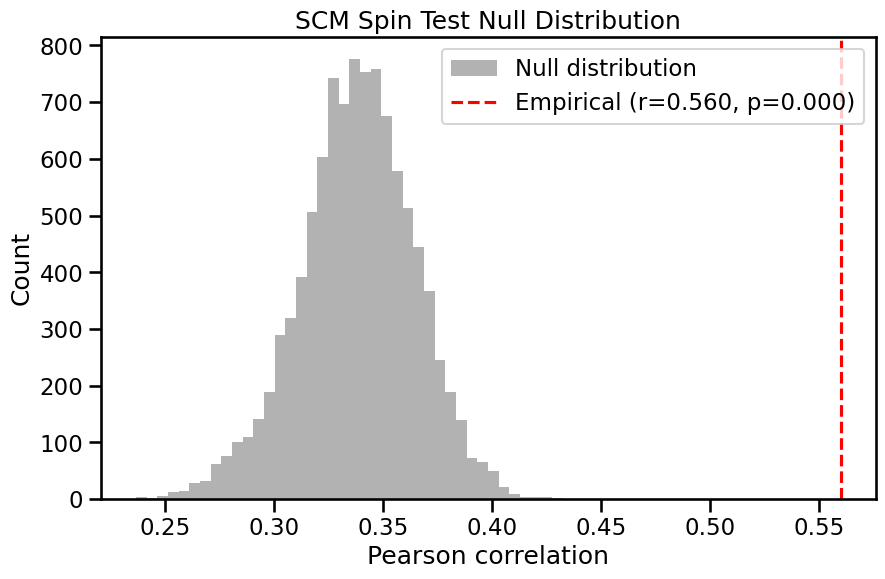

In [19]:
empirical_corr, p_value, null_distribution_SCM_10k = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_10k,
    model_type='SCM',
    sort_spins='mean_error_rank',
    n_perms=10000
)


permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950
permutation: 1000
permutation: 1050
permutation: 1100
permutation: 1150
permutation: 1200
permutation: 1250
permutation: 1300
permutation: 1350
permutation: 1400
permutation: 1450
permutation: 1500
permutation: 1550
permutation: 1600
permutation: 1650
permutation: 1700
permutation: 1750
permutation: 1800
permutation: 1850
permutation: 1900
permutation: 1950
permutation: 2000
permutation: 2050
permutation: 2100
permutation: 2150
permutation: 2200
permutation: 2250
permutation: 2300
permutation: 2350
permutation: 2400
permutation: 2450
permutation: 2500
permutation: 2550
permutation: 2600
permutation: 2650
permutation: 2700
permutation: 2750
permutation: 28

  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)



permutation: 5800
permutation: 5850
permutation: 5900
permutation: 5950
permutation: 6000
permutation: 6050
permutation: 6100
permutation: 6150
permutation: 6200
permutation: 6250
permutation: 6300
permutation: 6350
permutation: 6400
permutation: 6450
permutation: 6500
permutation: 6550
permutation: 6600
permutation: 6650
permutation: 6700
permutation: 6750
permutation: 6800
permutation: 6850
permutation: 6900
permutation: 6950
permutation: 7000
permutation: 7050
permutation: 7100
permutation: 7150
permutation: 7200
permutation: 7250
permutation: 7300
permutation: 7350
permutation: 7400
permutation: 7450


  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)



permutation: 7500
permutation: 7550
permutation: 7600
permutation: 7650
permutation: 7700
permutation: 7750
permutation: 7800
permutation: 7850
permutation: 7900
permutation: 7950
permutation: 8000
permutation: 8050
permutation: 8100
permutation: 8150
permutation: 8200
permutation: 8250
permutation: 8300
permutation: 8350
permutation: 8400
permutation: 8450
permutation: 8500
permutation: 8550
permutation: 8600
permutation: 8650
permutation: 8700
permutation: 8750
permutation: 8800
permutation: 8850
permutation: 8900
permutation: 8950
permutation: 9000
permutation: 9050
permutation: 9100
permutation: 9150
permutation: 9200
permutation: 9250
permutation: 9300
permutation: 9350
permutation: 9400
permutation: 9450
permutation: 9500
permutation: 9550
permutation: 9600
permutation: 9650
permutation: 9700
permutation: 9750
permutation: 9800
permutation: 9850
permutation: 9900
permutation: 9950


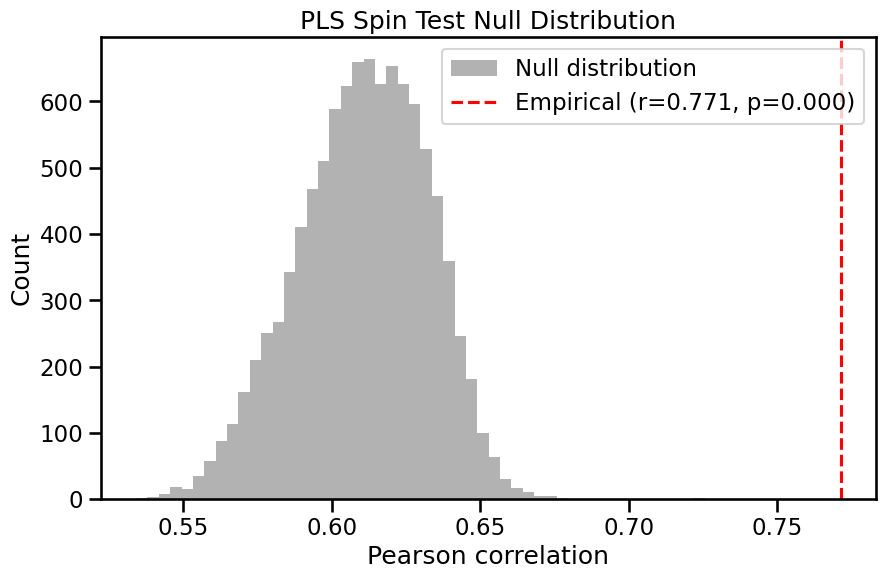

In [20]:
empirical_corr, p_value, null_distribution_PLS_10k = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_10k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=10000
)

In [23]:
spins_df_10k = spins_df_10k.sort_values('mean_error_rank', ascending=True)
spins_df_10k['pearsonr_SCM'] = null_distribution_SCM_10k
spins_df_10k['pearsonr_PLS'] = null_distribution_PLS_10k
#spins_df_10k.to_csv('./data/enigma/10000_null_spins.csv', index=False)

In [24]:
spins_df_10k

cortical_spins  \
417   [1, 6, 4, 0, 2, 69, 12, 68, 5, 3, 10, 7, 15, 1...   
6245  [21, 15, 193, 191, 190, 194, 19, 143, 144, 189...   
7911  [122, 6, 3, 1, 4, 69, 12, 0, 2, 9, 10, 7, 19, ...   
9921  [175, 172, 137, 117, 170, 136, 113, 138, 134, ...   
5302  [0, 1, 2, 6, 4, 5, 12, 7, 8, 3, 9, 11, 15, 92,...   
...                                                 ...   
9064  [159, 128, 164, 157, 161, 163, 158, 129, 160, ...   
1230  [44, 47, 42, 49, 104, 174, 184, 103, 141, 46, ...   
8040  [76, 77, 79, 74, 72, 81, 129, 80, 94, 27, 128,...   
9440  [63, 66, 67, 83, 62, 53, 30, 54, 111, 84, 144,...   
266   [84, 76, 53, 80, 83, 48, 126, 50, 82, 72, 74, ...   

                                      subcortical_spins  cortical_cost  \
417   [0, 33, 2, 29, 1, 5, 6, 7, 8, 3, 10, 11, 12, 1...    9868.096901   
6245  [2, 9, 13, 12, 5, 6, 52, 49, 33, 7, 48, 10, 32...    9643.503872   
7911  [31, 48, 47, 52, 46, 28, 30, 34, 7, 51, 10, 49...   10587.258836   
9921  [53, 55, 46, 49, 54, 48, 5, 33, 4, 51, 32, 31,...    9722.312520   
5302  [53, 55, 54, 48, 49, 50, 13, 9, 6, 52, 2, 47, ...    8802.011771   
...                                                 ...            ...   
9064  [50, 55, 53, 52, 49, 48, 43, 34, 32, 54, 0, 51...   15133.379157   
1230  [10, 46, 55, 50, 28, 51, 32, 31, 42, 52, 8, 54...   15090.569712   
8040  [7, 54, 43, 53, 6, 8, 13, 46, 12, 34, 48, 49, ...   14793.927720   
9440  [33, 4, 55, 51, 32, 5, 28, 42, 43, 50, 13, 54,...   15577.466231   
266   [34, 51, 52, 53, 8, 6, 43, 42, 28, 49, 32, 54,...   15024.913799   

      subcortical_cost    total_cost  mean_error_rank  total_cost_rank  \
417         612.102793  10480.199694        16.666667              8.0   
6245       1295.744937  10939.248809       151.666667             13.0   
7911       3044.556141  13631.814976       152.333333            441.0   
9921       2569.249866  12291.562385       181.666667             82.0   
5302       2648.851327  11450.863098       215.333333             26.0   
...                ...           ...              ...              ...   
9064       3055.667316  18189.046474      9577.000000           9737.0   
1230       2961.466725  18052.036437      9587.000000           9571.0   
8040       3024.581674  17818.509395      9590.666667           9200.0   
9440       2429.806374  18007.272605      9658.000000           9513.0   
266        3188.614543  18213.528342      9732.333333           9763.0   

      SA_error_rank  poly_error_rank  standardized_SA_error  ...   poly_a1  \
417             4.0             38.0               0.609384  ...  1.096968   
6245          374.0             68.0               1.591515  ...  1.061321   
7911            6.0             10.0               0.621569  ...  1.082026   
9921          340.0            123.0               1.547915  ...  1.074919   
5302            5.0            615.0               0.609793  ...  1.025928   
...             ...              ...                    ...  ...       ...   
9064         9736.0           9258.0               8.016635  ...  0.850472   
1230         9314.0           9876.0               7.709224  ...  0.831457   
8040         9803.0           9769.0               8.094710  ...  0.826775   
9440         9974.0           9487.0               8.494684  ...  0.839477   
266          9994.0           9440.0               8.677172  ...  0.844169   

       poly_a2   poly_a3       poly_a4  poly_a1_PCA  poly_a2_PCA  poly_a3_PCA  \
417  -0.028375  0.000318 -1.088029e-06     1.049116    -0.032066     0.000341   
6245 -0.028272  0.000327 -1.137008e-06     1.052804    -0.034917     0.000388   
7911 -0.029022  0.000340 -1.210387e-06     1.050206    -0.032869     0.000358   
9921 -0.030991  0.000379 -1.374732e-06     1.043412    -0.034916     0.000391   
5302 -0.025585  0.000291 -1.015320e-06     0.997005    -0.028756     0.000293   
...        ...       ...           ...          ...          ...          ...   
9064 -0.017753  0.000168 -4.127311e-07     0.81976

Generate distribution for all spatial random permutations

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


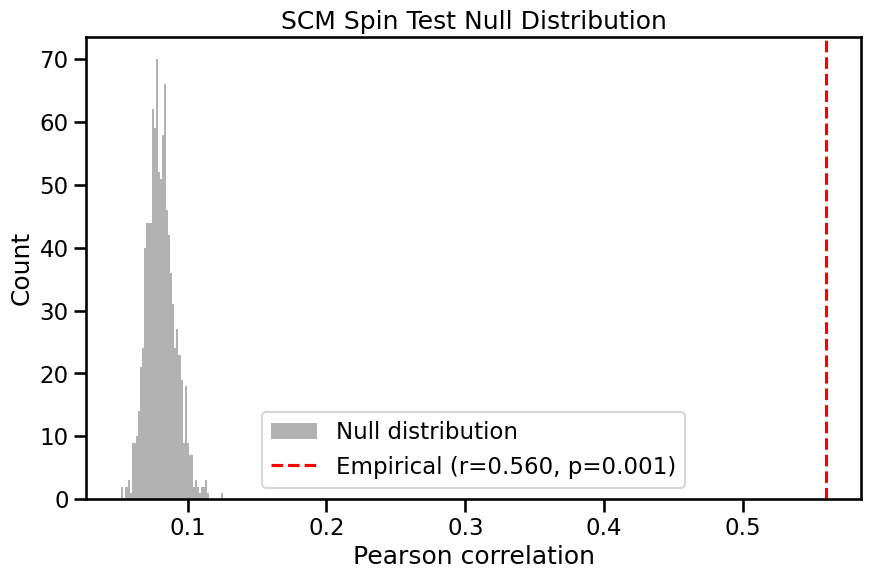

In [14]:
empirical_corr, p_value, null_distribution_SCM_spatial_random = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_spatial_random,
    model_type='SCM',
    sort_spins=None,
    n_perms=1000
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


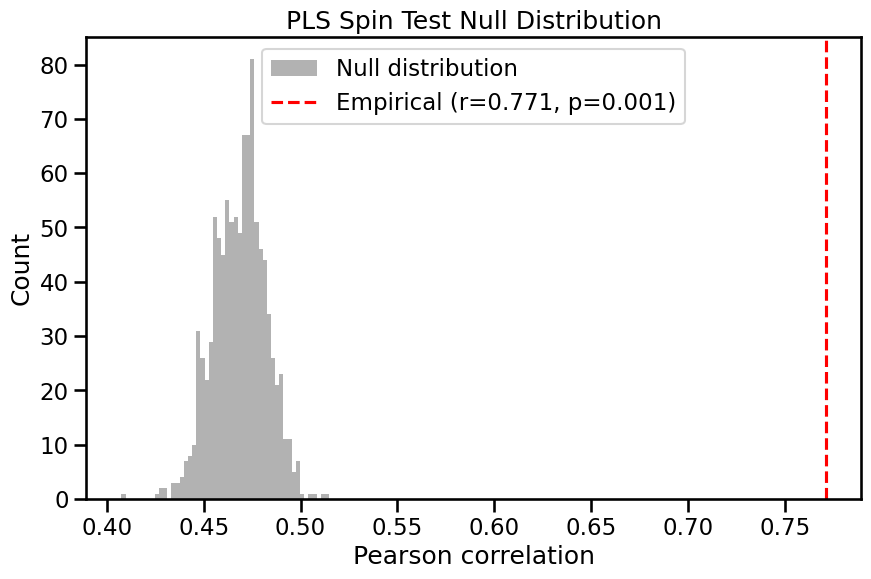

In [15]:

empirical_corr, p_value, null_distribution_PLS_spatial_random = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_spatial_random,
    model_type='PLS',
    sort_spins=None,
    n_perms=1000
)

In [ ]:
spins_df_spatial_random['pearsonr_SCM'] = null_distribution_SCM_spatial_random
spins_df_spatial_random['pearsonr_PLS'] = null_distribution_PLS_spatial_random
spins_df_spatial_random

#spins_df_spatial_random.to_csv('./data/enigma/1000_spatial_random_spins.csv', index=False)

Generate distribution for true random permutations

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


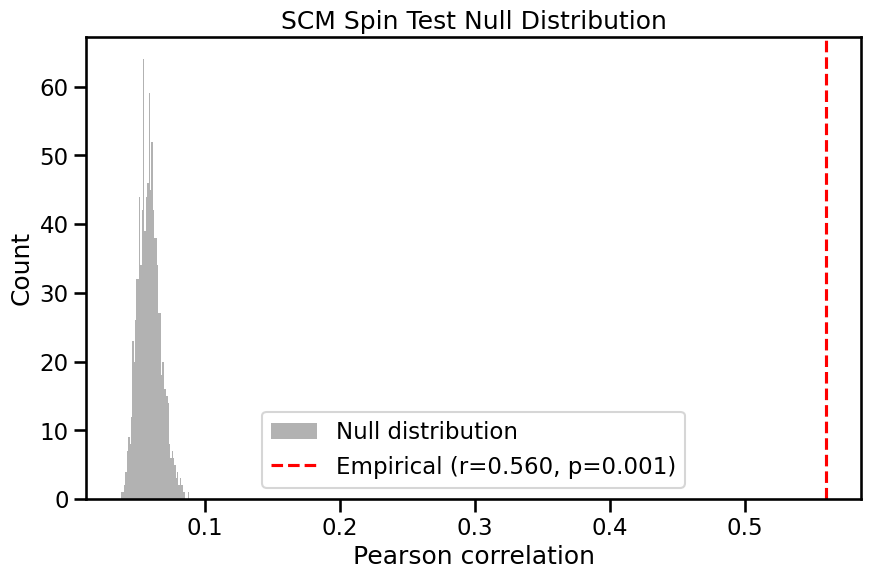

In [84]:
empirical_corr, p_value, null_distribution_SCM_random = run_spin_test_random(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_random,
    model_type='SCM',
    n_perms=1000
)

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850


  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)



permutation: 900
permutation: 950


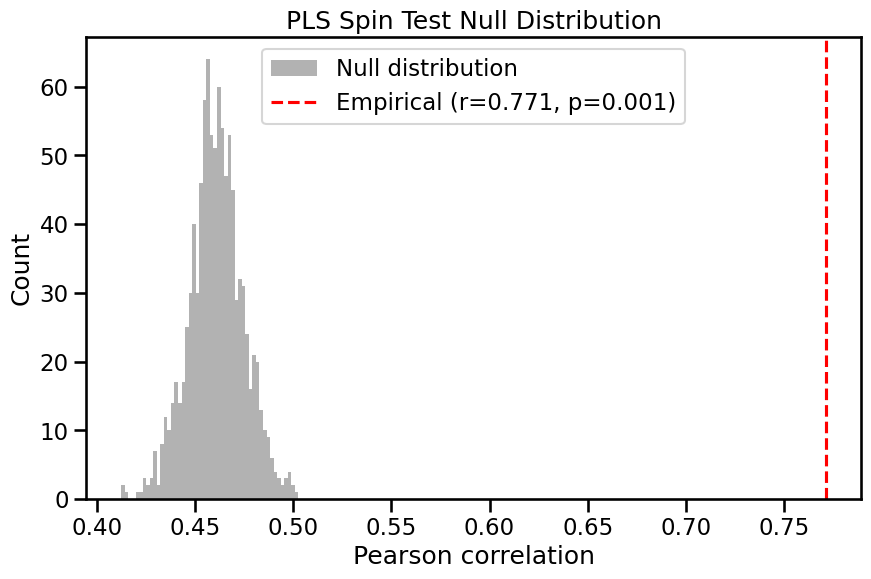

In [85]:
empirical_corr, p_value, null_distribution_PLS_random = run_spin_test_random(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_random,
    model_type='PLS',
    n_perms=1000
)

In [86]:
spins_df_random['pearsonr_SCM'] = null_distribution_SCM_random
spins_df_random['pearsonr_PLS'] = null_distribution_PLS_random
# spins_df_random.to_csv('./data/enigma/1000_true_random_spins.csv', index=False)